
2. Предобработка данных
Исходный размер датасета: (6497, 13)
Пропуски в данных: 0
Дубликатов: 1177
Размер после удаления дубликатов: (5320, 13)
Размер после удаления выбросов: (4866, 13)

Распределение новых классов качества:
quality_class
1    0.440814
0    0.363337
2    0.195849
Name: proportion, dtype: float64

3. Визуализация данных и корреляционный анализ


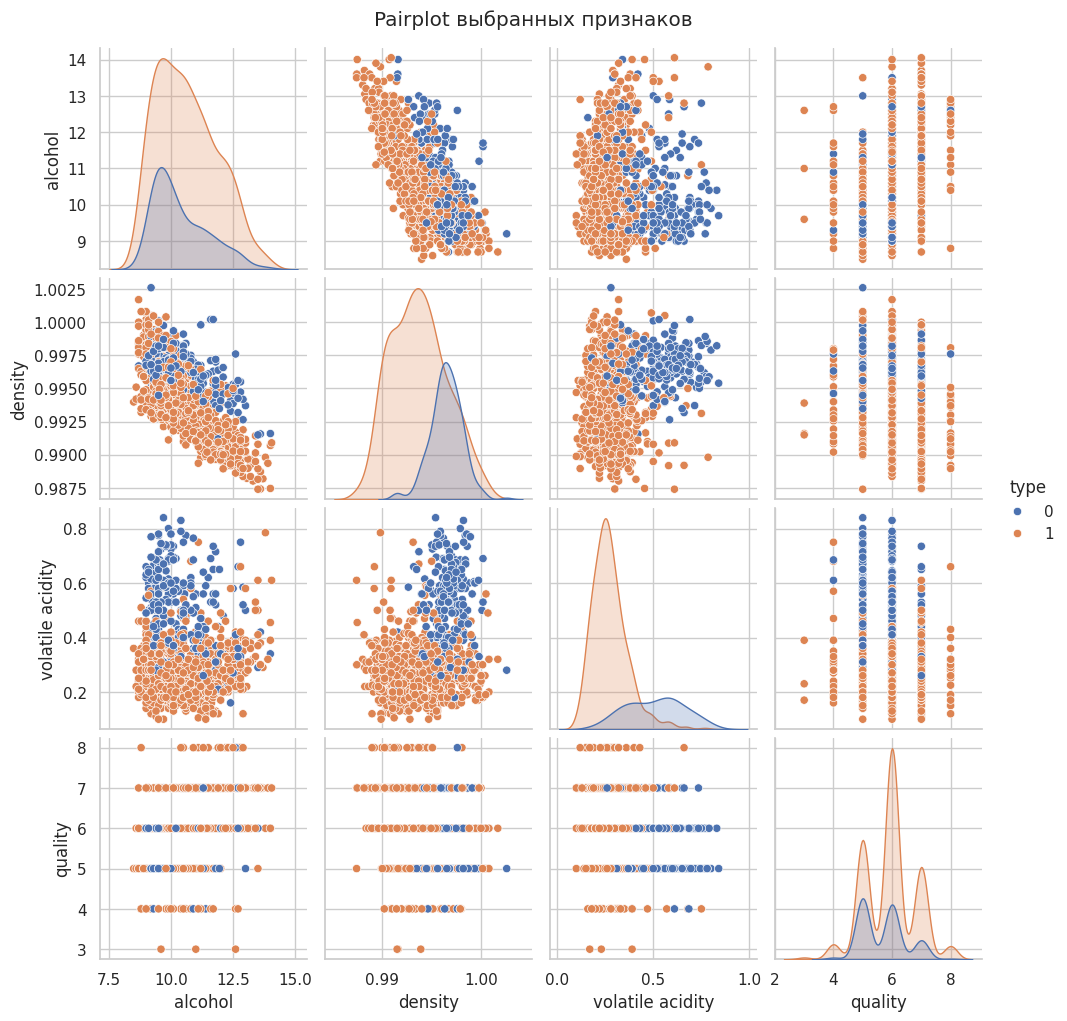

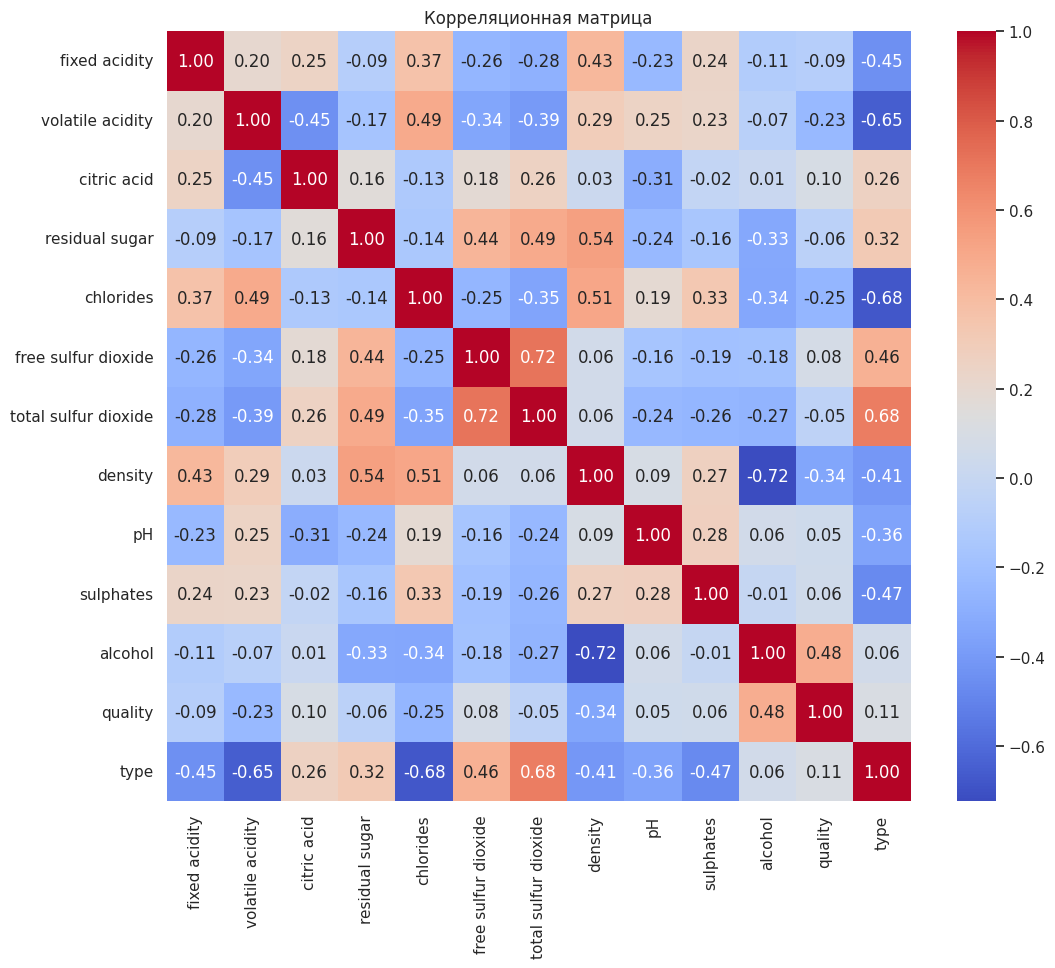

Корреляция с исходным качеством (quality):
quality                 1.000000
alcohol                 0.479517
type                    0.107537
citric acid             0.096992
free sulfur dioxide     0.079572
sulphates               0.056841
pH                      0.047374
total sulfur dioxide   -0.047739
residual sugar         -0.058677
fixed acidity          -0.090211
volatile acidity       -0.232526
chlorides              -0.253664
density                -0.343990
Name: quality, dtype: float64

4. Регрессионный анализ (линейная регрессия)
MSE: 0.5182
R²: 0.2721


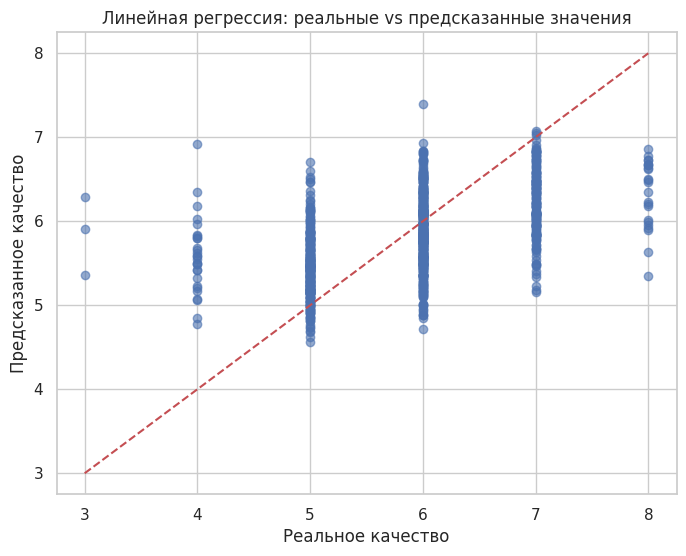


5. Классификация (3 класса качества)

Decision Tree — Accuracy: 0.5123203285420944
              precision    recall  f1-score   support

           0       0.56      0.53      0.55       354
           1       0.51      0.51      0.51       429
           2       0.44      0.49      0.46       191

    accuracy                           0.51       974
   macro avg       0.50      0.51      0.51       974
weighted avg       0.51      0.51      0.51       974


KNN — Accuracy: 0.5903490759753593
              precision    recall  f1-score   support

           0       0.65      0.64      0.64       354
           1       0.56      0.60      0.58       429
           2       0.55      0.49      0.52       191

    accuracy                           0.59       974
   macro avg       0.59      0.57      0.58       974
weighted avg       0.59      0.59      0.59       974


6. Кластерный анализ (K-Means)


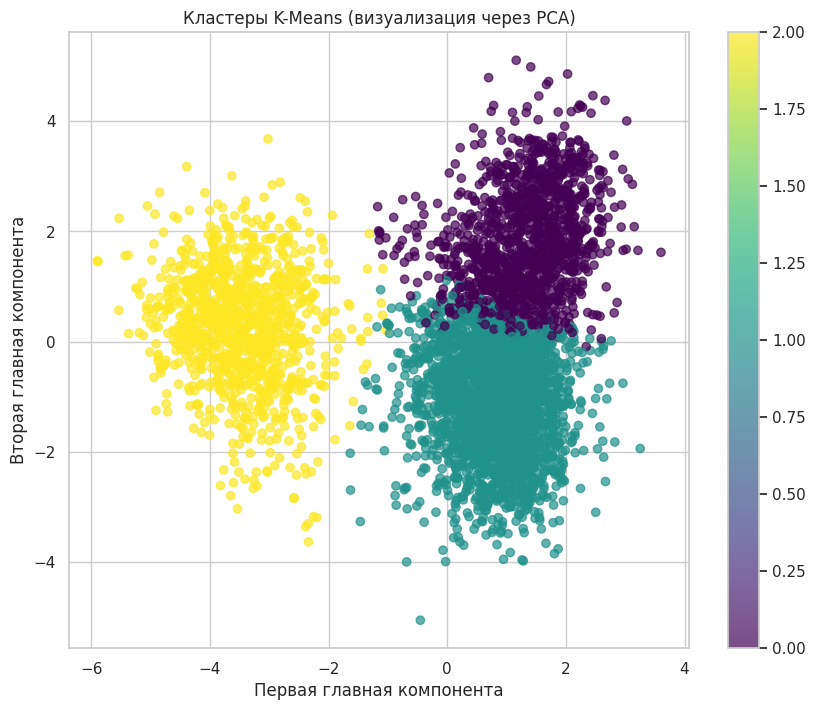


7. Нейронные сети (классификация на 3 класса)
Epoch 50/300, Loss: 0.6122
Epoch 100/300, Loss: 0.7467
Epoch 150/300, Loss: 0.6134
Epoch 200/300, Loss: 0.5272
Epoch 250/300, Loss: 0.6232
Epoch 300/300, Loss: 0.6188

Точность нейронной сети на тестовой выборке: 0.5749 (57.5%)
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       354
           1       0.57      0.40      0.47       429
           2       0.48      0.72      0.57       191

    accuracy                           0.57       974
   macro avg       0.57      0.61      0.57       974
weighted avg       0.58      0.57      0.57       974


Проект завершён. Все этапы выполнены.


In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

sns.set(style="whitegrid")
%matplotlib inline



# ===================================
# 2. Загрузка и предобработка данных
# ===================================
print("\n2. Предобработка данных")

url_red = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
url_white = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

df_red = pd.read_csv(url_red, sep=";")
df_white = pd.read_csv(url_white, sep=";")
df_red['type'] = 0   # красное
df_white['type'] = 1 # белое

df = pd.concat([df_red, df_white], ignore_index=True)
print(f"Исходный размер датасета: {df.shape}")

# Проверка пропусков
print("Пропуски в данных:", df.isnull().sum().sum())

# Удаление дубликатов
print(f"Дубликатов: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Размер после удаления дубликатов: {df.shape}")

# Удаление выбросов по правилу 3σ (только по признакам, не по quality)
feature_cols_outlier = df.columns.drop(['quality', 'type'])
for col in feature_cols_outlier:
    mean = df[col].mean()
    std = df[col].std()
    df = df[(df[col] > mean - 3*std) & (df[col] < mean + 3*std)]
print(f"Размер после удаления выбросов: {df.shape}")

# Создание 3 классов качества (ДО масштабирования!)
def bin_quality(q):
    if q <= 5: return 0   # плохое
    elif q == 6: return 1 # среднее
    else: return 2        # хорошее

df['quality_class'] = df['quality'].apply(bin_quality)
print("\nРаспределение новых классов качества:")
print(df['quality_class'].value_counts(normalize=True))

# ===================================
# 3. Визуализация и корреляционный анализ
# ===================================
print("\n3. Визуализация данных и корреляционный анализ")

# Pairplot
sample_df = df.sample(min(1000, len(df)), random_state=42)
sns.pairplot(sample_df, vars=['alcohol', 'density', 'volatile acidity', 'quality'], hue='type', diag_kind='kde')
plt.suptitle("Pairplot выбранных признаков", y=1.02)
plt.show()

# Корреляционная матрица
corr = df.drop('quality_class', axis=1).corr()  # quality_class не нужен в корреляции
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()

print("Корреляция с исходным качеством (quality):")
print(corr['quality'].sort_values(ascending=False))

# ===================================
# 4. Регрессионный анализ
# ===================================
print("\n4. Регрессионный анализ (линейная регрессия)")

X_reg = df.drop(['quality', 'quality_class'], axis=1)
y_reg = df['quality']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

model_lr = LinearRegression()
model_lr.fit(X_train_reg_scaled, y_train_reg)
pred_reg = model_lr.predict(X_test_reg_scaled)

print(f"MSE: {mean_squared_error(y_test_reg, pred_reg):.4f}")
print(f"R²: {r2_score(y_test_reg, pred_reg):.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test_reg, pred_reg, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel("Реальное качество")
plt.ylabel("Предсказанное качество")
plt.title("Линейная регрессия: реальные vs предсказанные значения")
plt.show()

# ===================================
# 5. Классификация (Decision Tree и KNN)
# ===================================
print("\n5. Классификация (3 класса качества)")

X_class = df.drop(['quality', 'quality_class'], axis=1)
y_class = df['quality_class']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)

scaler_class = StandardScaler()
X_train_c_scaled = scaler_class.fit_transform(X_train_c)
X_test_c_scaled = scaler_class.transform(X_test_c)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_c_scaled, y_train_c)
pred_dt = dt.predict(X_test_c_scaled)
print("\nDecision Tree — Accuracy:", accuracy_score(y_test_c, pred_dt))
print(classification_report(y_test_c, pred_dt))

# KNN
knn = KNeighborsClassifier(n_neighbors=7)  # 7 часто лучше для этого датасета
knn.fit(X_train_c_scaled, y_train_c)
pred_knn = knn.predict(X_test_c_scaled)
print("\nKNN — Accuracy:", accuracy_score(y_test_c, pred_knn))
print(classification_report(y_test_c, pred_knn))

# ===================================
# 6. Кластерный анализ (K-Means)
# ===================================
print("\n6. Кластерный анализ (K-Means)")

scaler_kmeans = StandardScaler()
X_kmeans_scaled = scaler_kmeans.fit_transform(X_class)

kmeans = KMeans(n_clusters=3, random_state=42)  # 3 кластера — под наши классы
kmeans.fit(X_kmeans_scaled)
df['cluster'] = kmeans.labels_

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_kmeans_scaled)

plt.figure(figsize=(10,8))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df['cluster'], cmap='viridis', alpha=0.7)
plt.title("Кластеры K-Means (визуализация через PCA)")
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.colorbar(scatter)
plt.show()

# ===================================
# 7. Нейронные сети (PyTorch)
# ===================================
print("\n7. Нейронные сети (классификация на 3 класса)")

# Class weights для борьбы с дисбалансом
class_weights = compute_class_weight('balanced', classes=np.unique(y_class), y=y_class)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Тензоры
X_train_tensor = torch.tensor(X_train_c_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_c.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_c_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Улучшенная модель
class WineNet(nn.Module):
    def __init__(self, input_size=X_class.shape[1], num_classes=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model_nn = WineNet()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

# Обучение
epochs = 300
for epoch in range(epochs):
    model_nn.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_nn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Оценка на отложенном тесте
model_nn.eval()
with torch.no_grad():
    outputs = model_nn(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    acc_nn = accuracy_score(y_test_c, predicted.numpy())
    print(f"\nТочность нейронной сети на тестовой выборке: {acc_nn:.4f} ({acc_nn*100:.1f}%)")
    print(classification_report(y_test_c, predicted.numpy()))
